In [1]:
import random
from random import sample
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders import HelmertEncoder
from transformers import RobertaForMaskedLM, RobertaTokenizer

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
dataset = pd.read_csv('../data/part_10.csv')
dataset.sample()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
51574,77.37.246.177,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_1 like ...,447,200,REQUEST_ARGS_KEYS,#flash_close,#flash_close,AVdnBq_eq1Ppo9zF8eB9


### пропущенные значения

<AxesSubplot: >

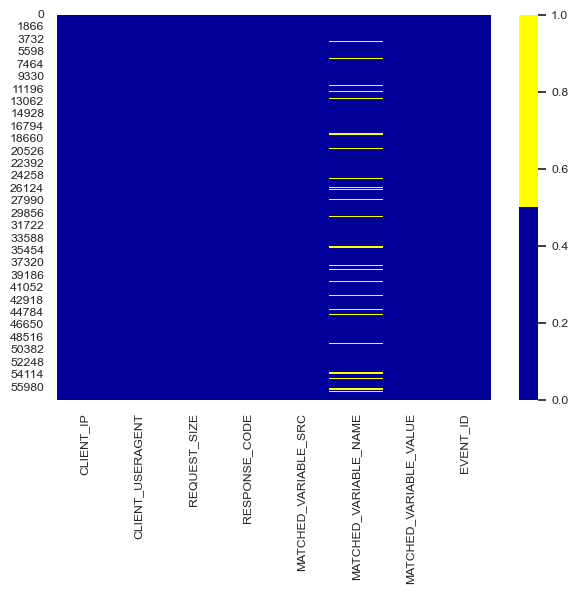

In [3]:
colours = ['#000099', '#ffff00'] 
sns.set(rc={'figure.figsize':(7,5)})
sns.set(font_scale=0.8)
sns.heatmap(dataset.isnull(), cmap=sns.color_palette(colours))

In [4]:
dataset = dataset[~dataset.isnull().all(1)]

for col in dataset.columns:
    pct_missing = np.mean(dataset[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

CLIENT_IP - 0%
CLIENT_USERAGENT - 1%
REQUEST_SIZE - 0%
RESPONSE_CODE - 0%
MATCHED_VARIABLE_SRC - 0%
MATCHED_VARIABLE_NAME - 8%
MATCHED_VARIABLE_VALUE - 0%
EVENT_ID - 0%


In [5]:
dataset.isnull().sum()

CLIENT_IP                    0
CLIENT_USERAGENT           321
REQUEST_SIZE                44
RESPONSE_CODE               68
MATCHED_VARIABLE_SRC       108
MATCHED_VARIABLE_NAME     4671
MATCHED_VARIABLE_VALUE     155
EVENT_ID                   172
dtype: int64

### ДУБЛИКАТЫ

In [6]:
dataset[dataset.duplicated(keep=False)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
4144,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11506,¿b_,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11804,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18615,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20342,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25760,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31594,¢×˾û8äyªû¬Aü,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38144,¿b_,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43187,¢×˾û8äyªû¬Aü,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dataset = dataset.drop(index=dataset[dataset.duplicated(keep=False)].index)

In [8]:
key = ['CLIENT_USERAGENT',	'RESPONSE_CODE',	'MATCHED_VARIABLE_SRC',	'MATCHED_VARIABLE_NAME',
       'MATCHED_VARIABLE_VALUE',]
print(len(dataset[key][dataset[key].duplicated(keep=False)]))
dataset[key][dataset[key].duplicated(keep=False)].head()

54


,CLIENT_USERAGENT,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE
27,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.q,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height..."
1922,NaN,NaN,NaN,NaN,NaN
2552,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,200,REQUEST_POST_ARGS,©æ(4È,NaN
3231,NaN,NaN,NaN,NaN,NaN
3371,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,200,REQUEST_POST_ARGS,©æ(4È,NaN


In [9]:
for i in ['CLIENT_IP', 'EVENT_ID']:
    print(f'всего {i}', len(dataset[i].value_counts().keys()))
    print(f'уникальных {i} ', len(set(dataset[i].value_counts().keys())))

print('всего в датасете записей ', len(dataset))

всего CLIENT_IP 24937
уникальных CLIENT_IP  24937
всего EVENT_ID 54410
уникальных EVENT_ID  54410
всего в датасете записей  57829


In [10]:
# TODO: кодировки поменять?

### CLIENT_USERAGENT

In [11]:
rndm =  np.array(sample(range(len(dataset)), 1))[0]
rndm

26172

In [12]:
for i in range(rndm,(rndm+3)):
    print(dataset.loc[i, 'CLIENT_USERAGENT'])
    print()

Mozilla/5.0 (compatible; Nmap Scripting Engine; https://nmap.org/book/nse.html)

Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:57.0) Gecko/20100101 Firefox/57.0

Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.116 Safari/537.36



In [13]:
dataset[dataset['CLIENT_USERAGENT'].isnull()].sample(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
55176,188.138.92.55,NaN,89,404,REQUEST_URI,NaN,//tmp/20160925123187indo.php.vob,AVdhXSoCq1Ppo9zF5F4g
32056,188.138.92.55,NaN,161,404,REQUEST_URI,NaN,//tmp/20160925059975indo.php.vob,AVdfxMjGq1Ppo9zF4kbI
55244,78.110.50.113,NaN,144,200,REQUEST_URI,NaN,/system/icons/eprodukt/566.jpg,AVdZ-LbFq1Ppo9zF1OpK


In [14]:
dataset['bad_useragent'] = np.where(dataset['CLIENT_USERAGENT'].isna(), 1, 0)
dataset['CLIENT_USERAGENT'] = dataset['CLIENT_USERAGENT'].fillna('Неизвестно')

### MATCHED_VARIABLE_NAME, MATCHED_VARIABLE_VALUE

In [15]:
dataset[['MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE' ]].sample(10)

,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE
18221,REQUEST_URI,NaN,/www/tasks/4/11/image054.gif
38726,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516644847685
25289,REQUEST_ARGS,action,post;quote=166137;topic=3249.0;last_msg=167620
38638,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516370278037
41751,REQUEST_GET_ARGS,url,http://www.scoop.it/t/direct-marketing-by-mayz...
49512,REQUEST_COOKIES,REQUEST_COOKIES.LtpaToken2,NfMX fOAMfci8EyEADa2M2wJ8CChYNfoFw1r/BbfHHb/AC...
21262,REQUEST_GET_ARGS,REQUEST_GET_ARGS.date_arch,19-05-2017
48619,REQUEST_PATH,REQUEST_PATH,/special/documents/rfm/100
7393,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,624014182
30388,REQUEST_GET_ARGS,REQUEST_GET_ARGS.e,wqT_3QLlB_SkAeUDAAADANYABQEIje3k0wUQ0b3k9fyylO...


In [16]:
len(dataset['MATCHED_VARIABLE_NAME'].value_counts().keys()), len(dataset['MATCHED_VARIABLE_VALUE'].value_counts().keys())

(3209, 57611)

In [17]:
dataset['MATCHED_VARIABLE_NAME'].value_counts()[-3:]

srchPat%255B4%255D                                                 1
/content/goods/item[25]:Comment                                    1
XâO½#*«
WÒ:©¹µMÖ\täÛk17qòmʂ3³vާÏ?æÞÅË
Ëî<èMkq,,ÜÆì½8    1
Name: MATCHED_VARIABLE_NAME, dtype: int64

In [18]:
dataset[dataset['MATCHED_VARIABLE_NAME'].isnull()].sample(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent
21861,217.69.134.62,Mozilla/5.0 (compatible; Linux x86_64; Mail.RU...,376,304,REQUEST_URI,NaN,/sitemap_ru.xml,AVdWZpVpq1Ppo9zFy2_j,0
37486,178.154.234.129,Mozilla/5.0 (compatible; YandexBlogs/0.99; rob...,243,404,REQUEST_URI,NaN,/investigation2.xml,AVdeHbk7q1Ppo9zF3pG6,0
27535,5.79.68.55,Mozilla/5.0 (compatible; LinkpadBot/1.08; +htt...,538,404,REQUEST_URI,NaN,/catalog/oboi/belorusskie_oboi/1_06_goryachee_...,AVdmYUswq1Ppo9zF8BLh,0


In [19]:
dataset['bad_name'] = np.where(dataset['MATCHED_VARIABLE_NAME'].isna(), 1, 0)
dataset['MATCHED_VARIABLE_NAME'] = dataset['MATCHED_VARIABLE_NAME'].fillna('Неизвестно')

In [20]:
dataset[dataset['MATCHED_VARIABLE_VALUE'].isnull()].sample(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name
57306,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,148181,200,REQUEST_POST_ARGS,RLcÎA?t%SÓîûñ޻,NaN,NaN,0,0
45834,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,101539,200,REQUEST_POST_ARGS,u(ùb|zâ¹ó]ªk7%UIû£ ¿çò®«_5âÐ$q¥Xý'úVÊéúu¯_...,NaN,NaN,0,0
47828,7?2éNìüçõýøRy¯ëúð¯}¸´_zÆu $ñ¥Æëä$üë...,Неизвестно,NaN,NaN,NaN,Неизвестно,NaN,NaN,1,1


In [21]:
dataset['bad_value'] = np.where(dataset['MATCHED_VARIABLE_VALUE'].isna(), 1, 0)
dataset['MATCHED_VARIABLE_VALUE'] = dataset['MATCHED_VARIABLE_VALUE'].fillna('Неизвестно')

### MATCHED_VARIABLE_SRC

In [22]:
dataset['MATCHED_VARIABLE_SRC'].value_counts()

REQUEST_GET_ARGS                    20812
REQUEST_COOKIES                      9303
REQUEST_HEADERS                      4930
REQUEST_PATH                         4011
REQUEST_ARGS                         3729
RESPONSE_HEADERS                     3364
REQUEST_POST_ARGS                    3304
REQUEST_URI                          3143
REQUEST_XML                          1959
REQUEST_METHOD\';\'REQUEST_CONTE      812
REQUEST_URI\';\'REQUEST_ARGS          666
REQUEST_ARGS_KEYS                     639
REQUEST_JSON                          587
REQUEST_METHOD\';\'REQUEST_HEADE      227
CLIENT_USERAGENT                      133
CLIENT_SESSION_ID                      42
REQUEST_QUERY                          35
RESPONSE_BODY                          22
REQUEST_CONTENT_TYPE                    6
REQUEST_FILES                           5
CLIENT_IP                               1
Name: MATCHED_VARIABLE_SRC, dtype: int64

In [23]:
dataset[dataset['MATCHED_VARIABLE_SRC'] == 'REQUEST_FILES'].sample(5)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name,bad_value
47482,108.179.199.10,Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...,8884,301,REQUEST_FILES,file,Neko.php\\x0\\x0\\x0\\x0\\x0\\x0\\x0\\x0\\x0\\...,6jV3NmYBrgKk_RFNxhTc,0,0,0
15121,37.209.206.246,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,968,301,REQUEST_FILES,file,<?php eval(base64_decode(c3lzdGVtKGJhc2U2NF9kZ...,QTDhNWYBrgKk_RFN4OnO,0,0,0
8543,109.195.49.179,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,159543,200,REQUEST_FILES,reference to,http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd,AVdqyNGwq1Ppo9zF-M6B,0,0,0
20569,96.44.128.250,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,612,404,REQUEST_FILES,Filedata,8D9AAEEC4D8E4439299046B8CDB3F782<?php @eval($...,ejHrNWYBrgKk_RFNsDI6,0,0,0
15659,203.162.127.193,Mozilla 15,1049,404,REQUEST_FILES,module,PK\n\\x0\\x0\\x0\\x0\\x0RanIjðýU1\\x0\\x0\\x...,wUvZGmQB5cBXmMW1VuHM,0,0,0


In [24]:
### комбинированные признаки

In [25]:
# признак MATCHED_VARIABLE_NAME	== MATCHED_VARIABLE_VALUE	
dataset['var_name_eql_value'] = np.where(dataset['MATCHED_VARIABLE_NAME'] == dataset['MATCHED_VARIABLE_VALUE'], 1, 0 )
dataset['var_name_eql_value'].value_counts()

0    57152
1      677
Name: var_name_eql_value, dtype: int64

In [ ]:
# TODO: вытаскивать из CLIENT_USERAGENT curl, linux, mozilla 

In [28]:
# проверка, что MATCHED_VARIABLE_SRC в MATCHED_VARIABLE_NAME
dataset['variable_src_in_name'] = dataset.apply(lambda x: str(x.MATCHED_VARIABLE_SRC) in str(x.MATCHED_VARIABLE_NAME), axis=1) * 1
dataset['variable_src_in_name'].value_counts()

1    41839
0    15990
Name: variable_src_in_name, dtype: int64

In [29]:
dataset[dataset['variable_src_in_name'] == 0].sample(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name,bad_value,var_name_eql_value,variable_src_in_name
1553,95.108.181.97,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,297,200,REQUEST_URI,Неизвестно,/static/public/ru/.../{{_cabinetLink}}/luxtrai...,Cr6AJWQB5cBXmMW1nza9,0,1,0,0,0
6210,77.35.215.81,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,992,304,CLIENT_USERAGENT,Неизвестно,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,JTyQN2YBrgKk_RFNp6N1,0,1,0,0,0
1655,212.33.244.15,Mozilla/5.0 (Windows NT 5.1; rv:52.0) Gecko/20...,1191,403,REQUEST_METHOD\';\'REQUEST_HEADE,X-Requested-With\';\'CSRF_TOKEN,POST\';\'XMLHttpRequest\';\'14f25a2f95c5d6e276...,3bo0_mMBjksgoq1epLK2,0,0,0,0,0


In [30]:
dataset[dataset['MATCHED_VARIABLE_SRC'].isnull()].sample(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name,bad_value,var_name_eql_value,variable_src_in_name
51034,Remote Code Execution,AVdfO1xNq1Ppo9zF4RVM,5c8a3f211f83e224ff052d2e66df4418,NaN,NaN,Неизвестно,Неизвестно,NaN,0,1,1,1,0
55871,ÕBÿ,AVddkIdNq1Ppo9zF3QzL,NaN,NaN,NaN,Неизвестно,Неизвестно,NaN,0,1,1,1,0
4185,\n¨Àç۷­|Ó\r¼Ł;z¢±Ç×íVë¨'2yKï#rïyúÔX»R薲s...,SQL Injection,AVdfPawjq1Ppo9zF4R4n,5cae7339ed82e2077c9a5da7c92c698a,NaN,Неизвестно,Неизвестно,NaN,0,1,1,1,0


In [31]:
dataset['bad_src'] = np.where(dataset['MATCHED_VARIABLE_SRC'].isna(), 1, 0)
dataset['MATCHED_VARIABLE_SRC'] = dataset['MATCHED_VARIABLE_SRC'].fillna('Неизвестно')

### EVENT_ID

In [32]:
dataset['unknown_event'] = np.where(dataset['EVENT_ID'].isna(), 1, 0)
dataset['EVENT_ID'] = dataset['EVENT_ID'].fillna('Неизвестно')

### REQUEST_SIZE

In [33]:
dataset['REQUEST_SIZE'] = pd.to_numeric(dataset['REQUEST_SIZE'], errors='coerce')
dataset.loc[50, 'REQUEST_SIZE']

nan

In [34]:
dataset['bad_req_size'] = np.where(dataset['REQUEST_SIZE'].isna(), 1, 0)

In [37]:
dataset[dataset['REQUEST_SIZE'].isna()][:3]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name,bad_value,var_name_eql_value,variable_src_in_name,bad_src,unknown_event,bad_req_size


In [38]:
dataset['REQUEST_SIZE'].fillna(-1, inplace=True)
dataset['REQUEST_SIZE'] = dataset['REQUEST_SIZE'].astype('int')

### RESPONSE_CODE

In [39]:
dataset['RESPONSE_CODE'].value_counts()[:1]

200    25771
Name: RESPONSE_CODE, dtype: int64

In [40]:
dataset['RESPONSE_CODE'].value_counts()[-3:]

82b4c42ac7edc647d27de21ceb791491    1
429                                 1
7ccc451ad8a2981f1e6f7eb6a5813246    1
Name: RESPONSE_CODE, dtype: int64

In [41]:
dataset['RESPONSE_CODE'] = pd.to_numeric(dataset['RESPONSE_CODE'], errors='coerce')
dataset['bad_resp_code'] = np.where(dataset['RESPONSE_CODE'].isna(), 1, 0)
dataset[dataset['RESPONSE_CODE'].isna()][:3]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name,bad_value,var_name_eql_value,variable_src_in_name,bad_src,unknown_event,bad_req_size,bad_resp_code
50,"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T...",SQL Injection,-1,NaN,Неизвестно,Неизвестно,Неизвестно,Неизвестно,0,1,1,1,0,1,1,1,1
162,Remote Code Execution,AVdtgf8uq1Ppo9zF_hyd,-1,NaN,Неизвестно,Неизвестно,Неизвестно,Неизвестно,0,1,1,1,0,1,1,1,1
1308,"~@.*"")ۅ",SQL Injection,-1,NaN,Неизвестно,Неизвестно,Неизвестно,Неизвестно,0,1,1,1,0,1,1,1,1


In [42]:
dataset['RESPONSE_CODE'].fillna(-1, inplace=True)
dataset['RESPONSE_CODE'] = dataset['RESPONSE_CODE'].astype('int')

In [44]:
dataset.to_csv('../data/cat_num.csv', index=False)

In [45]:
### UUID?

In [46]:
cat_features = list(dataset.loc[:, dataset.dtypes == object].columns)

num_features = list(set(dataset.columns).difference(set(cat_features)))

In [49]:
# TODO: признак по апишке 
cat_features.remove('CLIENT_IP')

In [50]:
dataset[cat_features].sample()

,CLIENT_USERAGENT,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
9375,Mozilla/5.0 (compatible; AhrefsBot/5.2; +http:...,REQUEST_GET_ARGS,REQUEST_GET_ARGS.id,79335,O4z9IGQB5cBXmMW1IRId


### кодируем категориальные фичи 

In [ ]:
# работает очень долго и отваливается по памяти
# bd = BackwardDifferenceEncoder(drop_invariant=True)
# transformed_cat_f = bd.fit_transform(dataset[cat_features])
# transformed_cat_f.shape

In [51]:
# вытаскиваем эмбеддинги из текста
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large')

def get_token(x):
    """возвращает эмбеддинг текста"""
    return tokenizer(x, add_special_tokens=False)['input_ids']

dataset['random_feature'] = random.sample(range(1, len(dataset) + 1), len(dataset))

In [52]:
# TODO: как-то обрабаывать List[str] и List[List[str]] ?
for col in cat_features:
    dataset[col] = dataset[col].astype('str')

In [53]:
text_cols = cat_features

In [54]:
%%time
for col in text_cols:
    if col != text_cols[-1]:
        print(col, ' -->')
    dataset[col + '_median'] = dataset[col].apply(lambda x: np.median(get_token(x)))
    dataset[col + '_sum'] = dataset[col].apply(lambda x: np.sum(get_token(x)))
    dataset[col + '_mean'] = dataset[col].apply(lambda x: np.mean(get_token(x)))
    dataset[col + '_mode'] = dataset[col].apply(lambda x: stats.mode(get_token(x)).mode[0])
    dataset[col + '_min'] = dataset[col].apply(lambda x: np.min(get_token(x)))
    dataset[col + '_max'] = dataset[col].apply(lambda x: np.max(get_token(x)))
    dataset[col + '_std'] = dataset[col].apply(lambda x: np.std(get_token(x)))

CLIENT_USERAGENT  -->
MATCHED_VARIABLE_SRC  -->
MATCHED_VARIABLE_NAME  -->
MATCHED_VARIABLE_VALUE  -->
CPU times: user 4min 27s, sys: 389 ms, total: 4min 28s
Wall time: 4min 30s


In [55]:
for col in cat_features:
    dataset[col + '_count'] = dataset[col].map(dataset.groupby(col).size())

num_features = list(set(dataset.columns).difference(set(cat_features)))
num_features.append('CLIENT_IP')
len(num_features)

54

In [56]:
dataset[num_features].to_csv('../data/embeddings.csv', index=False)